Tiansheng Wu, Chiao Hsiao, Junchao Ma

In [ ]:
 import math as m
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
fsize = 15
plt.rcParams.update({'font.size': fsize})
from time import time

Functions 1: Loss Function

In [ ]:
#Define custom loss function
def loss_func(x_inp,x_bc_inp,x_ini_inp,u_inp,u_bc_inp,u_ini_inp,model,v,N,lambda_b):
  x = x_inp

  u0_pred = model(x_ini_inp);
  u1_pred = model(x_bc_inp);
  loss_bc = lambda_b*tf.reduce_sum((u0_pred-u_ini_inp)**2 + (u1_pred-u_bc_inp)**2)/N;

  # Get Burger's Eqn
  with tf.GradientTape() as g:
      g.watch(x)
      with tf.GradientTape() as gg:
        gg.watch(x)
        u = model(x)
      du_dtx = gg.batch_jacobian(u, x)
      du_dt = du_dtx[..., 0]
      du_dx = du_dtx[..., 1]
  d2u_dx2 = g.batch_jacobian(du_dx, x)[..., 1]

  u = du_dt + u*du_dx - v*d2u_dx2

  # Interior loss
  loss = tf.reduce_sum(u**2)/N;
  loss = tf.cast(loss, tf.float32);

  # Inital loss
  loss = loss + loss_bc

  return loss

Function 2: construct model

In [ ]:
def construct_model(Input_Dim,Output_Dim,width,depth,reg_param):
  model = Sequential();

  # Construct layers
  model.add(keras.Input(shape = (Input_Dim,))); #input

  for i in range(depth):
    if i == 0: # first layer, tanh activation
      model.add(Dense(width,
              kernel_initializer = 'RandomNormal', # initialization varies at each call of function
              bias_initializer = 'RandomNormal',
              kernel_regularizer = tf.keras.regularizers.l2(reg_param), # introduce L2 regularization for weight and bias
              bias_regularizer = tf.keras.regularizers.l2(reg_param),
              activation="tanh"));

    elif i == depth-1: # output layer, no activation
      model.add(Dense(output_dim,
              input_dim = width,
              kernel_initializer = 'RandomNormal', # initialization varies at each call of function
              bias_initializer = 'RandomNormal',
              kernel_regularizer = tf.keras.regularizers.l2(reg_param), # introduce L2 regularization for weight and bias
              bias_regularizer = tf.keras.regularizers.l2(reg_param),
              activation="tanh"));

    else: # intermediate hidden layers, tanh activations
      model.add(Dense(width,
              input_dim = width,
              kernel_initializer = 'RandomNormal', # initialization varies at each call of function
              bias_initializer = 'RandomNormal',
              kernel_regularizer = tf.keras.regularizers.l2(reg_param), # introduce L2 regularization for weight and bias
              bias_regularizer = tf.keras.regularizers.l2(reg_param),
              activation="tanh"));
  return model

Function 3: Train Network and Generate Plots

In [ ]:
def Train_N_Plot(x_inp,x_bc_inp,x_ini_inp,u_inp,u_bc_inp,u_ini_inp,v,width,depth,input_dim,output_dim,reg_param,lambda_b,N,max_epoch):
  print(f"=====================================\nModel for nu={v}");

  total_loss_loc = np.zeros(max_epoch)

  # Construct Model
  tf.keras.backend.clear_session()
  model = construct_model(input_dim,output_dim,width,depth,reg_param)
  model.summary()
  optimizer = keras.optimizers.Adam(learning_rate=1e-3)

  # Train Model
  for epoch in range(max_epoch):
    #print(epoch)
    with tf.GradientTape() as tape:

      loss = loss_func(x_inp,x_bc_inp,x_ini_inp,u_inp,u_bc_inp,u_ini_inp,model,v,N,lambda_b)
      loss += sum(model.losses)

      # Report History
      if (epoch+1)%(max_epoch) == 0 or (epoch+1)%250 == 0 or (epoch+1) == 1:
        print("Epoch: ",(epoch+1),"; loss: ",loss.numpy())

    grads = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    total_loss_loc[epoch] = loss.numpy()
  
  # Plot Loss
  plt.figure()
  plt.semilogy(total_loss_loc)
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  # Plot in 2D plane
  t_span = np.linspace(0,1,N)
  x_span = np.linspace(-1,1,N)
  t,x = np.meshgrid(t_span,x_span) # make a 2D mesh plane with t and x
  t_x = np.stack([t.flatten(), x.flatten()], axis=-1) # flatten the plane to (2,N) sets
  u = model.predict(t_x, batch_size=N)
  u = u.reshape(t.shape)

  fig = plt.figure(figsize=(14,4))
  gs = GridSpec(2, 6)
  plt.subplot(gs[0, :])
  plt.pcolormesh(t, x, u, cmap='rainbow')
  plt.xlabel('t')
  plt.ylabel('x')
  cbar = plt.colorbar(pad=0.05, aspect=10)
  cbar.set_label('u(t,x)')
  cbar.mappable.set_clim(-1, 1)

  t_cross_sections = [0,0.2,0.4,0.6,0.8,1]
  for i, t_cs in enumerate(t_cross_sections):
      plt.subplot(gs[1, i])
      t_x = np.stack([np.full(t_span.shape, t_cs), x_span], axis=-1)
      u = model.predict(t_x, batch_size=N)
      plt.plot(x_span, u)
      plt.title('t={}'.format(t_cs))
      plt.xlabel('x')
      plt.ylabel('u(t,x)')
  plt.tight_layout()
  plt.show()

  # 3D Plot
  t_span = np.linspace(0,1,N)
  x_span = np.linspace(-1,1,N)
  t,x = np.meshgrid(t_span,x_span) # make a 2D mesh plane with t and x
  t_x = np.stack([t.flatten(), x.flatten()], axis=-1) # flatten the plane to (2,N) sets
  u = model.predict(t_x, batch_size=N)
  u = u.reshape(t.shape)

  fig1 = plt.figure(figsize=(10,10))
  ax = plt.axes(projection='3d')

  ax.contour3D(t_span, x_span, u, 300, cmap='binary')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('u')
  plt.title("nu={}".format(v))
  plt.tight_layout()
  plt.show()

  return total_loss_loc, u


Parameters

In [ ]:
# define model params
v = [0.001];
width = 20; # 20
depth = 4; # 5
input_dim = 2;
output_dim = 1;
reg_param = 1e-7;
lambda_b = 10;
N = 1000;
max_epoch = 6000;

# interior conditions
np.random.seed(54)
x_int = np.random.rand(N,2); # [t;x], both [0,1]
x_int[...,1] = 2*(x_int[...,1]-0.5); # shift x to [-1,1]
u_int = np.zeros((N,1));

# initial conditions
np.random.seed(54)
x_ini = np.random.rand(N,2);
x_ini[...,0] = 0; #t = 0
x_ini[...,1] = 2*(x_ini[...,1]-0.5); # x, -1 to 1
u_ini = np.sin(-np.pi * x_ini[...,1]).reshape(N,1);

# boundary conditions
x_bc = np.random.rand(N,2); # t, 0 to 1
x_bc_list = [-1,1]
x_bc[...,1] = np.random.choice(x_bc_list,1); # -1 or 1
u_bc = np.zeros((N,1));

# merge inputs
x_bc_inp = [x_bc]
x_ini_inp = [x_ini]
x_inp = [x_int]
u_bc_inp = [u_bc]
u_ini_inp = [u_ini]
u_inp = [u_int]

x_inp = tf.reshape(x_inp,(-1,2));
x_inp = tf.cast(x_inp, tf.float32);
u_inp = tf.reshape(u_inp,(-1,1));
u_inp = tf.cast(u_inp, tf.float32);

x_bc_inp = tf.reshape(x_bc_inp,(-1,2));
x_bc_inp = tf.cast(x_bc_inp, tf.float32);
u_bc_inp = tf.reshape(u_bc_inp,(-1,1));
u_bc_inp = tf.cast(u_bc_inp, tf.float32);

x_ini_inp = tf.reshape(x_ini_inp,(-1,2));
x_ini_inp = tf.cast(x_ini_inp, tf.float32);
u_ini_inp = tf.reshape(u_ini_inp,(-1,1));
u_ini_inp = tf.cast(u_ini_inp, tf.float32);

Train and Plot Models

Model for nu=0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________
Epoch:  1 ; loss:  4.9398856
Epoch:  250 ; loss:  3.0319195
Epoch:  500 ; loss:  0.6214795
Epoch:  750 ; loss:  0.47900057
Epoch:  1000 ; loss:  0.34329128
Epoch:  1250 ; 

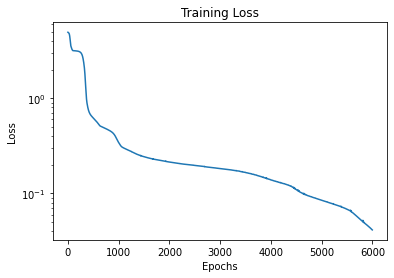

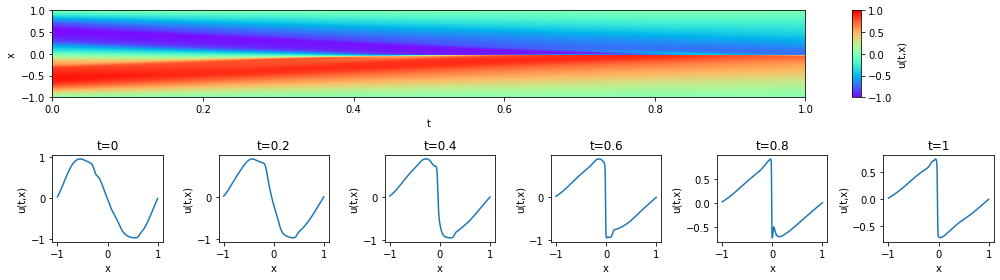

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


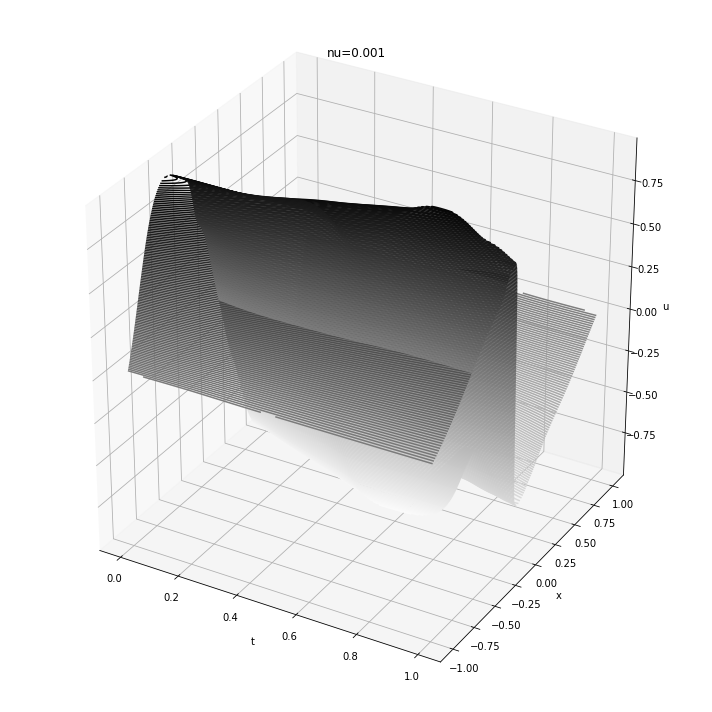

In [ ]:
u_colle = []
for this_v in v:
  total_loss_loc, u = Train_N_Plot(x_inp,x_bc_inp,x_ini_inp,u_inp,u_bc_inp,u_ini_inp,this_v,width,depth,input_dim,output_dim,reg_param,lambda_b,N,max_epoch)
  u_colle.append(u)